In [83]:
import h5py
import numpy as np
from scipy.optimize import curve_fit, root_scalar
from scipy.constants import h, k
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import os

In [84]:
from datetime import datetime

def sort_hdf5_filenames(filenames):
    """
    Sort a list of filenames in the format 'YYYY-MM-DD_HH_MM_SS.hdf5'
    by their embedded date and time.
    """
    def extract_datetime(filename):
        # Remove extension and parse the datetime
        timestamp_str = filename.replace('.hdf5', '')
        return datetime.strptime(timestamp_str, '%Y-%m-%d_%H_%M_%S')
    
    return sorted(filenames, key=extract_datetime)

In [ ]:
data_file_path = '/home/kth-user/Documents/data/'
fab_name = 'LKIPA_4'
h5_filename = 'LKIPA_4.hdf5'
sample = 'LKIPA_4_08-23'
path = os.path.join(data_file_path,fab_name, sample)

meas_list = os.listdir(path)
meas_list = sort_hdf5_filenames(meas_list)
meas = meas_list[-1]

f = h5py.File(os.path.join(path, meas))

measurements = sorted(list(f.keys())[:-1], key=int)
try:
    stepping = f.attrs["Stepping"]
except: 
    stepping = "no stepping recorded"
if stepping != "vdc":
    raise Exception(f"Incorrect measurement type, stepping type was: {stepping}")

In [86]:
#Extract resitance from comment
try:
    comment = f.attrs["Comment"]
except:
    comment = "No comment recorded"
print(comment)

dc_bias_resistance = 1.5e5

#Extract L_k from design
L_k_per_square = 36e-12
L_2_squares = 60
L_1_squares = 52/2

L_k = (L_2_squares + L_1_squares)*L_k_per_square

print(L_k)


Pump_port_connected_DC_port_connected_with_150kOhm&Cold_LP_filter
3.096e-09


['0', '1', '2', '3', '4', '5']
Linear fit of measurement 0:     f0 = 4429284251.203395,     k0 = 742191.7357356006,     ke = 638129.6541111125,     K_tot = 1380321.389846713,     Asym(q) = -4278.491723354376,     Baseline(a) = 4.221143402102452e-05,     Slope(b) = -1.4497196866831496e-14,     Phase shift = -1.4814117616811913
Linear fit of measurement 1:     f0 = 4428806801.760242,     k0 = 789626.5096247072,     ke = 641491.9270113658,     K_tot = 1431118.436636073,     Asym(q) = -683.5633190805466,     Baseline(a) = 4.1861975945932716e-05,     Slope(b) = -1.4421283108338237e-14,     Phase shift = -1.4830023334231928
Linear fit of measurement 2:     f0 = 4428282434.824038,     k0 = 818121.290253236,     ke = 644332.6296500871,     K_tot = 1462453.919903323,     Asym(q) = 2600.2062353816623,     Baseline(a) = 7.308974848999477e-05,     Slope(b) = -2.146506376732975e-14,     Phase shift = -1.4835297962247498
Linear fit of measurement 3:     f0 = 4427734630.423025,     k0 = 840099.408496

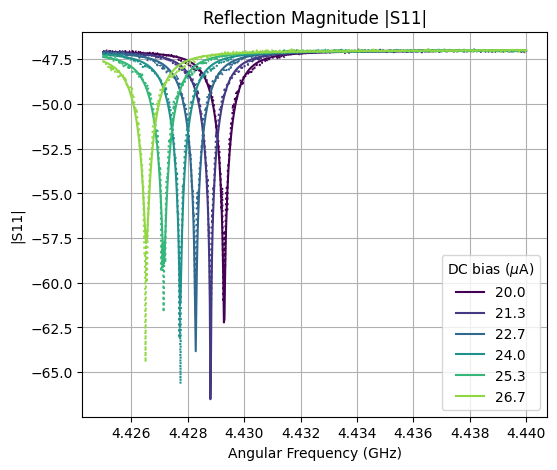

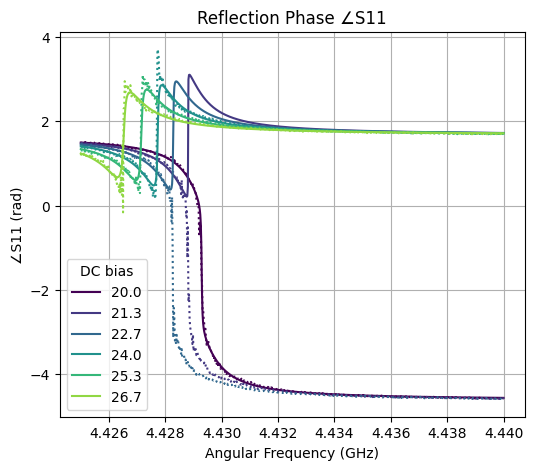

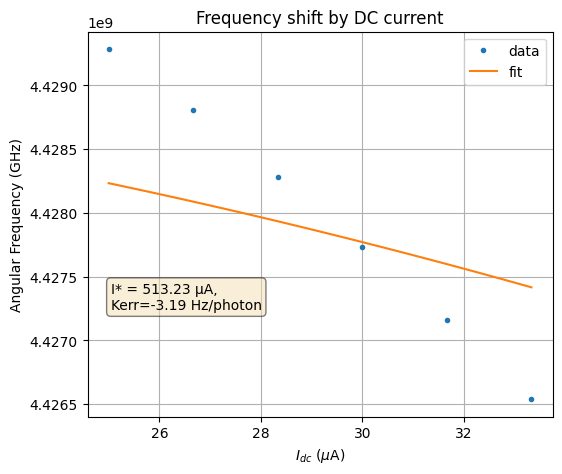

In [87]:
### Fitting low power measurements with linear model

### Model for a linear resonance peak.
def correct_delay(S_11_data, meas_freq, delay):
    return S_11_data * np.exp(2*np.pi* 1j * meas_freq * delay)
    
def correct_shift(S_11_data, phi = 0):
    return S_11_data * np.exp(1j * phi)

def linear_model_form(freq_array, freq0, k0, ke, q, a, b, phi):
    delta = freq_array - freq0
    num = (k0 - ke)/2 + 1j * delta + 1j*q
    den = (k0 + ke)/2 + 1j * delta
    S_11 = ((a + b*freq_array)) * np.exp(1j * phi) * ( num / den - D)
    return S_11

### Splits up the linear model in real and imaginary parts for fitting.
def linear_fitting_form(freq, freq0, k0, ke, q, a, b, phi):
    S_11 = linear_model_form(freq, freq0, k0, ke, q, a, b, phi)
    return np.concatenate([np.real(S_11), np.imag(S_11)])

def guess_losses(freq, S_11):

    S_11_mag = np.abs(S_11)
    
    # Find resonance frequency (minimum in magnitude)
    min_idx = np.argmin(S_11_mag)
    f0_guess = freq[min_idx]

    # Estimate total linewidth (FWHM)
    mag_dip = S_11_mag[min_idx]
    half_max = mag_dip + (1 - mag_dip)/2  # halfway between dip and 1

    indices_below = np.where(S_11_mag < half_max)[0]
    if len(indices_below) >= 2:
        f_low = freq[indices_below[0]]
        f_high = freq[indices_below[-1]]
        kappa_total = f_high - f_low
    else:
        kappa_total = (freq[-1] - freq[0]) / 100  # fallback guess

    return f0_guess, kappa_total

vdc_arr = np.array([])
I_dc_arr = np.array([])
f0_arr = np.array([])

sep_fig = True

plt.rcParams['axes.grid'] = True
if sep_fig:
    fig1, ax1 = plt.subplots(1, 1, figsize=(6, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(6, 5))
    fig3, ax3 = plt.subplots(1, 1, figsize=(6, 5))
else:
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
legend = []

cmap = cm['viridis']

print(measurements)

for i, meas_num in enumerate(measurements[:]):

    D = 0.1 #directionality, for highly over- or undercoupled measurements this needs to be included.

    S_11_data = f[str(meas_num)]['Data'][()]
    meas_freq = f[str(meas_num)]['Frequency'][()]
    vdc = f[str(meas_num)].attrs["vdc"]

    # delay = 75.5e-9
    delay = 1.085e-7

    S_11_data_corr_scaled = correct_delay(S_11_data, meas_freq, delay)

    # if i == 0:
    #     phi = -np.angle(S_11_data_corr_scaled[0])
    #     print(phi, i)

    # S_11_data_corr_scaled = correct_shift(S_11_data_corr_scaled, phi)

    S_11_real = np.real(S_11_data_corr_scaled)
    S_11_imag = np.imag(S_11_data_corr_scaled)

    S_11_fitting = np.concatenate([S_11_real, S_11_imag])

    f0_guess, k_tot_guess = guess_losses(meas_freq, S_11_data_corr_scaled)

    # init_guess = [f0_guess, k_tot_guess/5, 4*k_tot_guess/5, 0, 0.45, 0, 0]
    init_guess = [f0_guess, 1e5, 1e5, 0, 0.45, 0, 0]

    lin_popt, lin_pcov = curve_fit(linear_fitting_form, meas_freq, S_11_fitting, p0 = init_guess)

    freq0, k0, ke, q, a, b, phi = lin_popt

    f0_arr = np.append(f0_arr, freq0)
    vdc_arr = np.append(vdc_arr, vdc)
    I_dc = vdc/dc_bias_resistance
    I_dc_mu = I_dc*1e6
    I_dc_arr = np.append(I_dc_arr, I_dc)

    color = cmap(i / len(measurements))

    fitted_data = linear_fitting_form(meas_freq, *lin_popt)

    if sep_fig: 
        ax1.plot(meas_freq/1e9, 10*np.log10(abs(linear_model_form(meas_freq, *lin_popt))), color = color, label=f"{I_dc_mu:.1f}")
        ax2.plot(meas_freq/1e9, np.unwrap(np.angle(linear_model_form(meas_freq, *lin_popt))), color = color, label=f"{I_dc_mu:.1f}")

        ax1.plot(meas_freq/1e9, 10*np.log10(np.abs(S_11_data_corr_scaled)), color = color, label = '_nolegend_', ls = 'dotted')
        ax2.plot(meas_freq/1e9, np.unwrap(np.angle(S_11_data_corr_scaled)), color = color, label='_nolegend_', ls = 'dotted')
    else:
        ax[0].plot(meas_freq/1e9, 10*np.log10(abs(linear_model_form(meas_freq, *lin_popt))), color = color, label=f"{I_dc_mu:.1f}")
        ax[1].plot(meas_freq/1e9, np.unwrap(np.angle(linear_model_form(meas_freq, *lin_popt))), color = color, label='_nolegend_')

        ax[0].plot(meas_freq/1e9, 10*np.log10(np.abs(S_11_data_corr_scaled)), color = color, label = '_nolegend_', ls = 'dotted')
        ax[1].plot(meas_freq/1e9, np.unwrap(np.angle(S_11_data_corr_scaled)), color = color, label='_nolegend_', ls = 'dotted')

    print(f"Linear fit of measurement {meas_num}: \
    f0 = {freq0}, \
    k0 = {k0}, \
    ke = {ke}, \
    K_tot = {k0 + ke}, \
    Asym(q) = {q}, \
    Baseline(a) = {a}, \
    Slope(b) = {b}, \
    Phase shift = {phi}")

f0 = f0_arr[0]
L_ratio = float(1/5)

def dc_shift(I_dc, I_star):
    return f0 / (np.sqrt(1 + L_ratio * (I_dc / I_star)**2))

I_dc_arr = 1.25 * vdc_arr / dc_bias_resistance

init_guess = 200e-6
dc_shift_popt, dc_shift_pcov = curve_fit(dc_shift, I_dc_arr, f0_arr, init_guess)
I_star = dc_shift_popt[0]

I_linspace = np.linspace(I_dc_arr[0], I_dc_arr[-1])

if sep_fig:
    ax1.legend(title = r"DC bias ($\mu$A)")
    ax1.set_title(f"Reflection Magnitude |S11|")
    ax1.set_xlabel("Angular Frequency (GHz)")
    ax1.set_ylabel("|S11|")

    ax2.legend(title = "DC bias")
    ax2.set_title("Reflection Phase ∠S11")
    ax2.set_xlabel("Angular Frequency (GHz)")
    ax2.set_ylabel("∠S11 (rad)")

    ax3.plot(I_dc_arr/1e-6, f0_arr, ".", label = "data")
    ax3.plot(I_linspace/1e-6, dc_shift(I_linspace, I_star), label = "fit")
    ax3.set_title("Frequency shift by DC current")
    ax3.set_ylabel("Angular Frequency (GHz)")
    ax3.set_xlabel(r"$I_{dc}$ ($\mu$A)")

    ax3.legend()
else:
    ax[0].legend(title = "DC bias")
    ax[0].set_title(f"Reflection Magnitude |S11|")
    ax[0].set_xlabel("Angular Frequency (GHz)")
    ax[0].set_ylabel("|S11|")

    ax[1].set_title("Reflection Phase ∠S11")
    ax[1].set_xlabel("Angular Frequency (GHz)")
    ax[1].set_ylabel("∠S11 (rad)")

    ax[2].plot(I_dc_arr/1e-6, f0_arr, ".", label = "data")
    ax[2].plot(I_linspace/1e-6, dc_shift(I_linspace, I_star), label = "fit")
    ax[2].set_title("Frequency shift by DC current")
    ax[2].set_ylabel("Angular Frequency (GHz)")
    ax[2].set_xlabel(r"$I_{dc}$ ($\mu$A)")

    ax[2].legend()

I_RF = np.sqrt(2 * h * f0 / L_k)
print(I_RF)
print(I_star)
Kerr = f0*(1 - 1/np.sqrt(1 + L_ratio*(I_RF/I_star)**2))
print(Kerr)

title = f"I* = {I_star/1e-6:0.2f} μA"

textstr = fr"I* = {I_star/1e-6:0.2f} μA," + "\n" + rf"Kerr={-Kerr:.2f} Hz/photon"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

if sep_fig:
    ax3.text(0.05, 0.35, textstr, transform=ax3.transAxes, fontsize=10,
            verticalalignment='top',bbox = props)
else: 
    ax[2].text(0.05, 0.35, textstr, transform=ax[2].transAxes, fontsize=10,
            verticalalignment='top',bbox = props)

# ax[1, 1].plot(T_arr, np.array(ke_arr)/1e6, ".", label = r"$\kappa_e$")
# ax[1, 1].plot(T_arr, np.array(k0_arr)/1e6, ".", label = r"$\kappa_0$")
# ax[1, 1].set_title(r"Temperature dependence of $\kappa_0$ and $\kappa_e$")
# ax[1, 1].set_ylabel(r"$\kappa/2 \pi$ (MHz)")
# ax[1, 1].set_xlabel("Temperature (K)")
# ax[1, 1].legend()

print(f"v_dc: {vdc_arr}")

plt.show()


